## 3 Random walk in 1D

Text(0, 0.5, 'density')

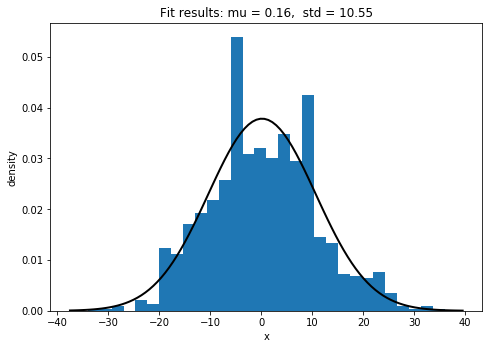

In [12]:
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

n_part = 1000   # number of particles
n_steps = 100   # number of steps
h = 1           # space steps size

pos = np.zeros([n_part])

for i in range(n_part):
    for j in range(n_steps):
        u = random.random()
        if u<0.5:
            step=-h
        else:
            step=h
        pos[i] = pos[i]+step
    
mu,std=norm.fit(pos)    
f=plt.figure()
ax=f.add_axes([0,0,1,1])
ax.hist(pos,bins=30,density=True)

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
ax.set_title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
ax.set_xlabel('x')
ax.set_ylabel('density')


## 5 Random walk in a potential
$$P(p,x) \propto e^{-\beta E(p,x)}$$ 
$$P^+=\frac{1}{1+\frac{P^-}{P^+}}$$
$$\frac{P^-}{P^+}=e^{-\beta[V(x-h)-V(x+h)]}$$

$$\rm{5.1}$$
$$  V(x)=kx $$

$$\rm{5.2}$$
$$V(x)=kx\ \rm{for}\ -3h<x<3h $$
$$V(x)=0\ \rm{otherwise}$$

$$\rm{5.3}$$
$$ V(x)=-k\ \rm{for}\ x<-3h$$
$$ V(x)=k(-1+2\frac{x+3h}{6h})\ \rm{for}\ -3h<x<3h $$
$$V(x)=k\ \rm{for}\ x>3h$$

kb = 8.6173303(50)×10−5	eV⋅K−1 Boltzmann constant
T=273+37 K

In [3]:
kb=8.617e-5 #eV/K
T=273+37 # K
beta=1/(kb*T) # eV
print("beta=",beta,"eV")

beta= 37.43537718014278 eV


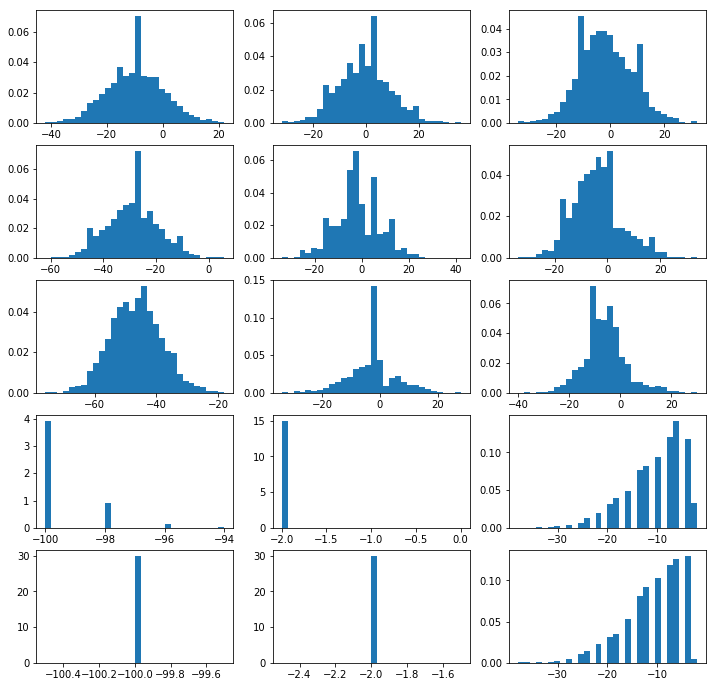

In [5]:
n_part = 2000   # number of particles
n_steps = 100   # number of steps
h = 1           # space steps size
dt = 1          # time step size
d = 1           # probability of the particle moving 
pos0 = np.zeros([n_part])

def potential1(x,h,bk):
    bV=bk*x
    return bV

def potential2(x,h,bk):

    if x>-3*h and x<3*h:
        bV=bk*x
    else:
        bV = 0
    return bV

def potential3(x,h,bk):
    if x<=-3*h:
        bV=-bk
    elif x>-3*h and x<=3*h:
        bV = bk*(-1+2*(x+3*h)/6/h)
    else:
        bV = bk
    return bV

def pplus(x,step,potential,bk):
    pm_over_pp=np.exp(-potential(x-step,step,bk)+potential(x+step,step,bk))
    pp=1/(1+pm_over_pp)
    return pp

def randWalk(pos_start, n_steps,h, potentialf,bk):
    n_part=len(pos_start)
    pos=pos_start.copy()
    for i in range(n_part):
        for j in range(n_steps):
            u = random.random()
            pp=pplus(pos[i],h,potentialf,bk)
            pm=1-pp
            if u<pm:
                step=-h
            else:
                step=+h
            pos[i] = pos[i]+step
    return pos

pos=np.empty([n_part,5,3])
kb=[0.1, 0.3, 0.5, 3, 7]
for i in range(len(kb)):
    pos[:,i,0]=randWalk(pos0,n_steps,h,potential1,kb[i])
    pos[:,i,1]=randWalk(pos0,n_steps,h,potential2,kb[i])
    pos[:,i,2]=randWalk(pos0,n_steps,h,potential3,kb[i])

(fig, ax)=plt.subplots(nrows = 5,ncols=3,figsize=[12,12])
for i in range(len(kb)):
    for ex in range(3):
        ax[i,ex].hist(pos[:,i,ex],bins=30,density=True)

    


## 7 Interplay between diffusion and voltage

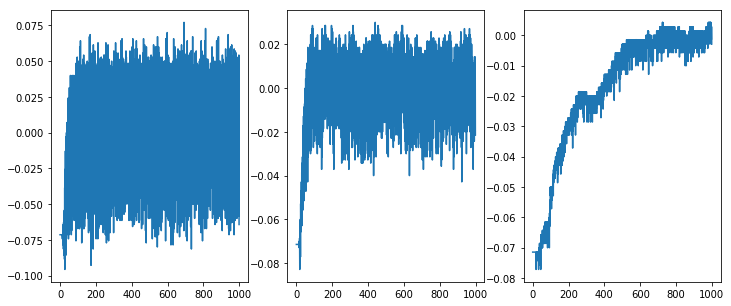

In [9]:
# membrane potentials
def VNa(x,h,bVNa0):
    beta=37.435
    V=x.copy()
    for i in range(len(x)):
        if x[i]>=-h and x[i]<=h:
            V[i]=bVNa0/beta
        else:
            V[i] = 0
    return V

def VK(x,h,bVK0):
    beta=37.435
    V=x.copy()
    for i in range(len(x)):
        if x[i]>=-h and x[i]<=h:
            V[i]=bVK0/beta
        else:
            V[i] = 0
    return V

# Vel electric potential difference between inside and outside
def Vel(x,h,posNa,posK,Cc):
    count_in=np.sum(posNa<-h)+np.sum(posK<-h)
    count_out=1450+50 # constant outside
    Vdiff=(count_in-count_out)*0.1/Cc
    V=x.copy()
    k=-Vdiff/2/h
    c=-k*h
    V[(x>=-h) & (x<=h)]=k*x[(x>=-h) & (x<=h)]+c
    V[x<-h]=Vdiff
    V[x>h]=0

    return V

def updateIonPos(x,pos,h,pot_arr):
    beta=37.435
    n_part=len(pos)
    for i in range(n_part):
        if (pos[i]<=x[0]+h):
            step=+h
        elif (pos[i]>=x[len(x)-1]-h):
            step=-h
        else:
            u = random.random()
            pm_over_pp=np.exp(-beta*(pot_arr[x==pos[i]-h]-pot_arr[x==pos[i]+h]))
            pp=1/(1+pm_over_pp)            
            pm=1-pp
            if u<pm:
                step=-h
            else:
                step=+h
        pos[i] = pos[i]+step
    return pos

def runRandWalk(x,h,t,posNa0,posK0,cc,bVNa0,bVK0):
    posNa=posNa0.copy()
    posK=posK0.copy()
    n_t=len(t)
    Vout=np.empty(len(t))
    for i in range(n_t):
        V=Vel(x,h,posNa,posK,Cc) # calculate electric potential
        Vout[i]=V[1]
        potNa=V+VNa(x,h,bVNa0)  
        potK=V+VK(x,h,bVK0)
        posNa=updateIonPos(x,posNa,h,potNa)
        posK=updateIonPos(x,posK,h,potK)
    return Vout,posNa,posK

L=50 # domain length
h=1 # size step
dt=1 # time step
n_t=1000 # number of time steps 500
Cc=70 # e mM/V concentration capacitance of the membrane

# each particle is 0.1 mM inside the cell
n_Na_in=50 
n_Na_out=1450
n_K_in=1400
n_K_out=50
posNa0=np.concatenate((-int(L/4)*np.ones(n_Na_in),int(L/4)*np.ones(n_Na_out)))
posK0=np.concatenate((-int(L/4)*np.ones(n_K_in),int(L/4)*np.ones(n_K_out)))

x=np.arange(-L/2,L/2+h,h)
t=np.arange(n_t)


memb_pot=[0,1,3]
V=np.empty([n_t,len(memb_pot)])
for i in range (len(memb_pot)):
    V[:,i],posNa,posK=runRandWalk(x,h,t,posNa0,posK0,Cc,memb_pot[i],memb_pot[i])

(fig, ax)=plt.subplots(nrows = 1,ncols=3,figsize=[12,5])
for i in range(len(memb_pot)):
    ax[i].plot(t,V[:,i])

#ax[1].hist(posNa,bins=30,density=True)
#ax[2].hist(posK,bins=30,density=True)

## 8 Simulating the action potential

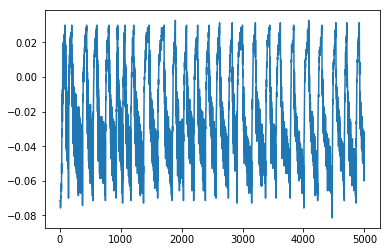

In [37]:
def ActionPotential(x,h,t,posNa0,posK0,cc):
    posNa=posNa0.copy()
    posK=posK0.copy()
    n_t=len(t)
    Vout=np.empty(len(t))
    bVNa0=50
    bVK0=50
    SPP_counter=0
    SPP_not_enough=False
    for i in range(n_t):
        V=Vel(x,h,posNa,posK,Cc) # calculate electric potential
        Vout[i]=V[1]
        if V[1]<=-0.07:
            bVNa0=1
            bVK0=50
        elif V[1]>=0.03:
            bVNa0=50
            bVK0=1
        # update potentilal for the two ions
        potNa=V+VNa(x,h,bVNa0) 
        potK=V+VK(x,h,bVK0)
        # move the ions
        posNa=updateIonPos(x,posNa,h,potNa)
        posK=updateIonPos(x,posK,h,potK)
        # run the sodium potassium pump
        SPP_counter +=1
        if SPP_counter%10 == 0 or SPP_not_enough==True:
            if len(posNa[posNa<-h])>=3 and len(posK[posK>h])>=2:
                posNa[np.where(posNa<-h)[0][0:3]]=h
                posK[np.where(posK>h)[0][0:2]]=-h
                SPP_counter = 0
                SPP_not_enough=False
            else:
                SPP_not_enough=True
    return Vout,posNa,posK

L=50 # domain length
h=1 # size step
dt=1 # time step
n_t=5000 # number of time steps 500
Cc=70 # e mM/V concentration capacitance of the membrane

# each particle is 0.1 mM inside the cell
n_Na_in=50 # was 60 here, typo?
n_Na_out=1450
n_K_in=1400
n_K_out=50
posNa0=np.concatenate((-int(L/4)*np.ones(n_Na_in),int(L/4)*np.ones(n_Na_out)))
posK0=np.concatenate((-int(L/4)*np.ones(n_K_in),int(L/4)*np.ones(n_K_out)))

x=np.arange(-L/2,L/2+h,h)
t=np.arange(n_t)

V,posNa,posK=ActionPotential(x,h,t,posNa0,posK0,Cc)

plt.plot(t,V)

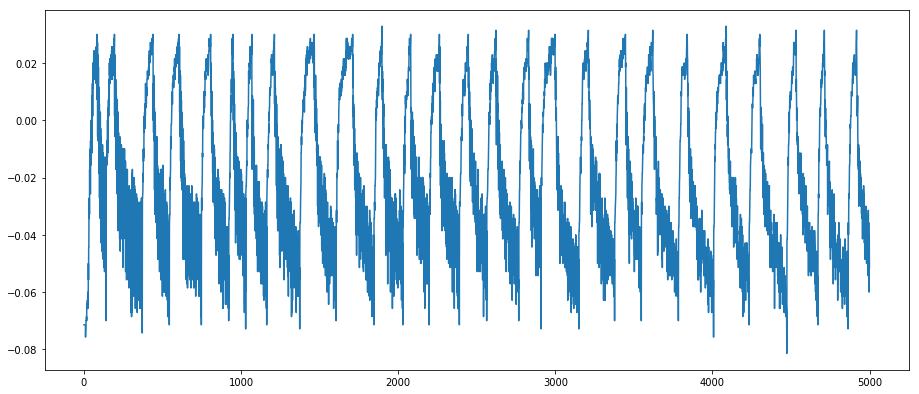

In [40]:
f=plt.figure(figsize=[12,5])
ax=f.add_axes([0,0,1,1])
ax.plot(t,V)